In [1]:
import math

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import pyro.contrib.gp as gp
from scipy.stats import norm
import torch
from torch.distributions.normal import Normal
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

# Comparison of acquisition functions in Bayesian optimization of ocean acoustic waveguides using Gaussian processes
For JASA Express Letters

## Abstract
Geoacoustic model optimization and inversion are computationally expensive endeavors. In cases where a parameter grid search is prohibitively expensive, optimization produces an approximated solution through sampling techniques such as Markov chain Monte Carlo, simulated annealing, and genetic algorithms.  More recent work proposes replacing such sampling with a Bayesian approach that uses a Gaussian process as a surrogate model of the objective function.  The surrogate model represents the posterior on the objective function and is updated with each sample evaluation.  As an alternative to sampling methods listed above, acquisition functions incorporate the uncertainty in the posterior to select the next point to be sampled and can greatly speed the optimization.  In this study, four common acquisition functions are described encompassing approaches that use manual tuning (upper confidence bound), improvement criteria (probability of improvement and expected improvement), and information criteria (entropy search).  Results are presented from an acoustic parameter search for a shallow water waveguide for each function.  Expected improvement is found to be the preferred acquisition function for the simulations, converging on the optimal solution more quickly than the other acquisition functions.

## 1. Introduction

## 2. Bayesian optimization using a Gaussian process

In Bayesian optimization, 

### Define objective function with constraints

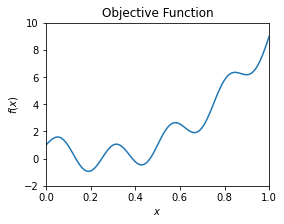

In [2]:
def f(x):
    y = (4 * x - 1)**2 + torch.sin(8 * math.pi * x)
    return y

x = torch.linspace(0, 1, 101)
y = f(x)

def plot_objective_function(x, y, show=True, figsize=(4,3)):
    fig = plt.figure(figsize=figsize)
    plt.plot(x, y)
    plt.xlim(0, 1)
    plt.ylim(-2, 10)
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.title(f'Objective Function')
    if show:
        plt.show()
    else:
        plt.close()
    return fig

_ = plot_objective_function(x, y)

### Model initialization

Initialize with two sample points and evaluate $f(x)$ at these points.  Set up the GP regression problem that will be used for determining the GP posterior.

In [3]:
X = torch.tensor([0.1, 0.8])
y = f(X)
gpmodel = gp.models.GPRegression(X, y, gp.kernels.Matern52(input_dim=1), noise=0 * torch.tensor(0.1), jitter=5.0e-4)

### Define Posterior Update Step

Define a function that will incorporate new evidence and update the posterior distribution.

In [4]:
def update_posterior(gpmodel, x_new):
    y = f(x_new)
    X = torch.cat([gpmodel.X, x_new])
    y = torch.cat([gpmodel.y, y])
    gpmodel.set_data(X, y)
    optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
    gp.util.train(gpmodel, optimizer)
    return gpmodel, optimizer

## 3. Acquisition Functions

The purpose of an acquisition function is to find the next point in the surrogate model to be evaluated.  Various methods exist to accomplish this step.

Manual:
- Lower confidence bound

Probabilistic (improvement-based) methods:
- Probability of Improvement
- Expected Improvement

Information-based methods:
- Entropy Search

There is a trade-off between exploration, e.g., sampling in regions of high variance, and exploitation, e.g., sampling in regions where the mean is well constrained.  Favoring exploitation implies relatively high confidence that a sample near a minimum has been obtained, and seeks to fine-tune the minimum by densely sampling near this point.  Favoring exploration seeks to 

Exploitation: Sampling around where the best mean is.
Exploration: Sampling around where the greatest variance is.


### 3.1 Lower confidence bound

$\alpha = \mu(x) - \kappa \sigma(x)$

In [5]:
def lower_confidence_bound(gpmodel, x, kappa=20):
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    return mu - kappa * sigma

### 3.2 Probability of Improvement

The probability of improvement (PI) is used to influence the sampling of the objective function by encoding whether or not a sample resulted in a better optimal solution.  Let $f' = \min \mathbf{f}$ be the minimal value of $f$ observed so far.  Now define a utility function which provides a reward if $f(x)$ yields a new minimum at some new $x$, and no reward otherwise:

$\begin{equation}
u(x) = 
    \begin{cases}
    0 & f(x) \gt f'\\
    1 & f(x) \leq f'
    \end{cases}
\end{equation}$

The probability of improvement is defined as the expected value of the utility function:

$\begin{equation}
\alpha_{PI}
= \mathbb{E}[u(x)\enspace|\enspace x, \mathcal{D}]
= \int\limits_{-\infty}^{f'} \mathcal{N}(f;\mu(x),K(x,x)) \,df
= \Phi(f';\mu(x), K(x,x))
\end{equation}$

The point that gives the maximum probability of improvement is selected, i.e., $x_{t+1} = \argmin \alpha_{PI}(x)$.

In [6]:
def probability_of_improvement(gpmodel, x, xi=0):
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    dist = Normal(mu, sigma)
    y_min = gpmodel.y.min()
    z = (mu - y_min - xi) / sigma
    return dist.cdf(z)

### 3.3 Expected Improvement

One of the limitations of using PI is that it does not encode the extent to which a sample improved the optimal solution.  Expected improvement (EI) overcomes this by evaluating $f$ at the point at which $f'$ is epxected to improve the most.  In this case, a utility function is defined as:

$\begin{equation}
u(x) = \max(0, f' - f(x))
\end{equation}$

In this case, the reward is equal to the improvement $f' - f(x)$ and zero otherwise.  EI is then defined as the expected value of the utility function:
$\begin{equation}
\alpha_{EI}
= \mathbb{E}[u(x)\enspace|\enspace x, \mathcal{D}]
= \int\limits_{-\infty}^{f'} (f' - f)\mathcal{N}(f;\mu(x),K(x,x)) \,df
= (f'-\mu(x))\Phi(f';\mu(x), K(x,x)) + K(x,x)\mathcal{N}(f;\mu(x),K(x,x))
\end{equation}$

The point that gives the maximum probability of improvement is selected, i.e., $x_{t+1} = \argmin \alpha_{PI}(x)$.  

In [7]:
def expected_improvement(gpmodel, x, xi=0):
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    dist = Normal(mu, sigma)
    y_min = gpmodel.y.min()
    a = (mu - y_min - xi)
    z = a / sigma
    return a * dist.cdf(z) + sigma * dist.pdf(z)

### 3.4 Entropy search

In [8]:
def entropy_search():
    return

### 3.5 Grid Search


## 4. Simulations

### Set up Bayesian Optimization Machinery

Define an acquisition function handler:

In [36]:
def acq_func_handler(func, gpmodel, x, kappa=20, xi=0.075):
    if func == "lcb":
        alpha = lower_confidence_bound(gpmodel, x, kappa=kappa)
    elif func == "ei":
        alpha = expected_improvement(gpmodel, x, xi=xi)
    elif func == "pi":
        alpha = probability_of_improvement(gpmodel, x, xi=xi)
    return alpha

Produce some candidates for the next sample point.

In [37]:
def find_a_candidate(gpmodel, acq_func, x_init, lower_bound=0, upper_bound=1):
    constraint = constraints.interval(lower_bound, upper_bound)
    unconstrained_x_init = transform_to(constraint).inv(x_init)
    unconstrained_x = unconstrained_x_init.clone().detach().requires_grad_(True)
    minimizer = optim.LBFGS([unconstrained_x], line_search_fn='strong_wolfe')
    
    def closure():
        minimizer.zero_grad()
        x = transform_to(constraint)(unconstrained_x)
        # alpha = lower_confidence_bound(gpmodel, x)
        alpha = acq_func_handler(acq_func, gpmodel, x)
        autograd.backward(unconstrained_x, autograd.grad(alpha, unconstrained_x))
        return alpha
    
    minimizer.step(closure)
    x_cand = transform_to(constraint)(unconstrained_x)
    return x_cand.detach()

Define a function that finds the next sample point using the acquisition function.

In [38]:
def next_x(gpmodel, acq_func, lower_bound=0, upper_bound=1, num_candidates=5):
    candidates = []
    acq_values = []
    
    x_init = gpmodel.X[-1:]
    for _ in range(num_candidates):
        x_cand = find_a_candidate(gpmodel, acq_func, x_init, lower_bound, upper_bound)
        # alpha = lower_confidence_bound(gpmodel, x_cand)
        alpha = acq_func_handler(acq_func, gpmodel, x_cand)
        candidates.append(x_cand)
        acq_values.append(alpha)
        x_init = x_cand.new_empty(1).uniform_(lower_bound, upper_bound)
    
    if acq_func == "lcb":
        argloc = torch.min(torch.cat(acq_values), dim=0)[1].item()
    else:
        argloc = torch.max(torch.cat(acq_values), dim=0)[1].item()
    return candidates[argloc]

In [39]:
# def plot(gs, gpmodel, acq_func, xmin, xlabel=None, with_title=True, ylim1=None, ylim2=None):
#     if xlabel is None:
#         xlabel = "xmin"
#     else:
#         xlabel = f"x{xlabel}"
    
#     Xnew = torch.linspace(0., 1., 101)
#     ax1 = plt.subplot(gs[0])
#     ax1.plot(gpmodel.X.detach().cpu().numpy(), gpmodel.y.detach().cpu().numpy(), "kx")
#     with torch.no_grad():
#         loc, var = gpmodel(Xnew, full_cov=False, noiseless=False)
#         sd = var.sqrt()
#         ax1.plot(Xnew.detach().cpu().numpy(), loc.detach().cpu().numpy(), "r", lw=2)
#         ax1.fill_between(Xnew.detach().cpu().numpy(), (loc - 2*sd).detach().cpu().numpy(), (loc + 2*sd).detach().cpu().numpy(), color="C0", alpha=0.3)
#     ax1.set_xlim(0., 1.)
#     if ylim1 is not None:
#         ax1.set_ylim(ylim1[0], ylim1[1])
#     ax1.set_title(f"Find {xlabel}")
#     if with_title:
#         ax1.set_ylabel("GP Regression")
    
#     ax2 = plt.subplot(gs[1])
#     with torch.no_grad():

#         # ax2.plot(Xnew.detach().cpu().numpy(), lower_confidence_bound(gpmodel, Xnew).detach().cpu().numpy())
#         # ax2.plot(xmin.detach().cpu().numpy(), lower_confidence_bound(gpmodel, xmin).detach().cpu().numpy(), "^", markersize=10, label=f"{xlabel} = {xmin.item():.5f}")
#         ax2.plot(Xnew.detach().cpu().numpy(), acq_func_handler(acq_func, gpmodel, Xnew).detach().cpu().numpy())
#         ax2.plot(xmin.detach().cpu().numpy(), acq_func_handler(acq_func, gpmodel, xmin).detach().cpu().numpy(), "^", markersize=10, label=f"{xlabel} = {xmin.item():.5f}")
#     ax2.set_xlim(0., 1.)
#     if ylim2 is not None:
#         ax2.set_ylim(ylim2[0], ylim2[1])
#     if with_title:
#         ax2.set_ylabel("Acquisition Function")
#     ax2.set_xlabel('x')
#     ax2.legend(loc=1)

Define the main optimization loop.

In [40]:
# func_list = ["lcb", "pi"]
# acq_func = func_list[0]

# X = torch.tensor([0.1, 0.8])
# y = f(X)
# gpmodel = gp.models.GPRegression(X, y, gp.kernels.Matern52(input_dim=1), noise=0 * torch.tensor(0.1), jitter=5.0e-4)

# optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
# gp.util.train(gpmodel, optimizer)

# for i in range(5):
#     xmin = next_x(gpmodel, acq_func)

#     fig = plt.figure(figsize=(6,7))
#     gs = gridspec.GridSpec(2,1)
#     plot(gs, gpmodel, acq_func, xmin, xlabel=i+1, with_title=True, ylim1=(-2, 10), ylim2=(-30, 10))
#     plt.show()

#     gpmodel, optimizer = update_posterior(gpmodel, xmin)

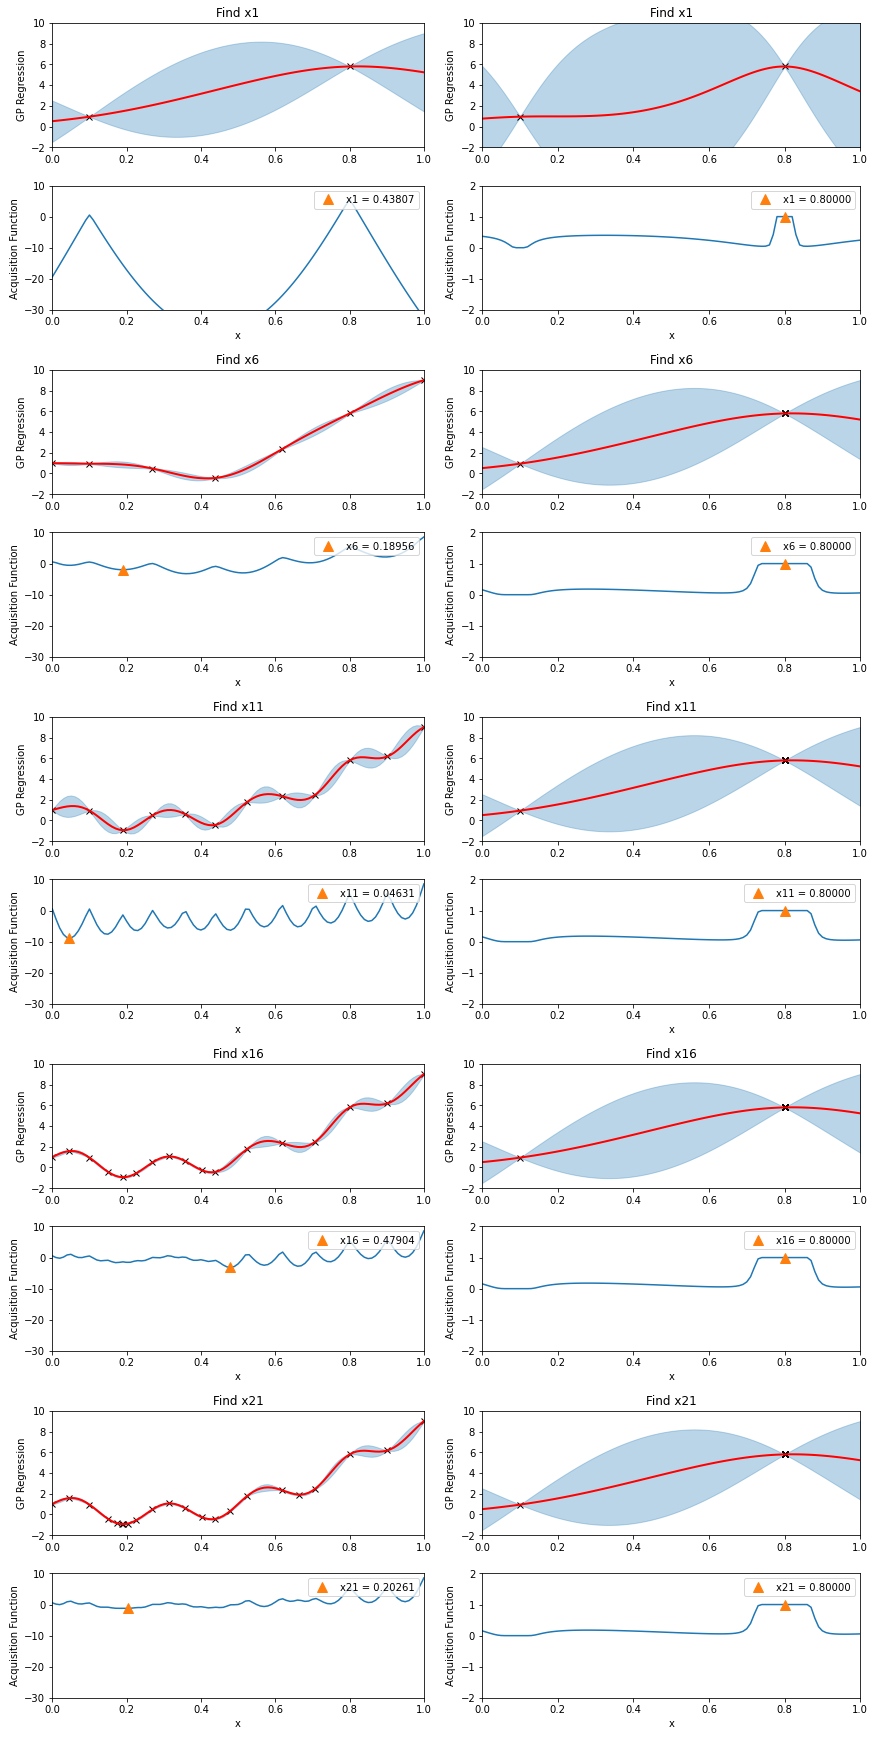

In [41]:
def plot(axs, gpmodel, acq_func, xmin, xlabel=None, with_title=True, ylim1=None, ylim2=None):
    if xlabel is None:
        xlabel = "xmin"
    else:
        xlabel = f"x{xlabel}"
    
    Xnew = torch.linspace(0., 1., 101)
    ax1 = axs[0]
    ax1.plot(gpmodel.X.detach().cpu().numpy(), gpmodel.y.detach().cpu().numpy(), "kx")
    with torch.no_grad():
        loc, var = gpmodel(Xnew, full_cov=False, noiseless=False)
        sd = var.sqrt()
        ax1.plot(Xnew.detach().cpu().numpy(), loc.detach().cpu().numpy(), "r", lw=2)
        ax1.fill_between(Xnew.detach().cpu().numpy(), (loc - 2*sd).detach().cpu().numpy(), (loc + 2*sd).detach().cpu().numpy(), color="C0", alpha=0.3)
    ax1.set_xlim(0., 1.)
    if ylim1 is not None:
        ax1.set_ylim(ylim1[0], ylim1[1])
    ax1.set_title(f"Find {xlabel}")
    if with_title:
        ax1.set_ylabel("GP Regression")
    
    ax2 = axs[1]
    with torch.no_grad():

        # ax2.plot(Xnew.detach().cpu().numpy(), lower_confidence_bound(gpmodel, Xnew).detach().cpu().numpy())
        # ax2.plot(xmin.detach().cpu().numpy(), lower_confidence_bound(gpmodel, xmin).detach().cpu().numpy(), "^", markersize=10, label=f"{xlabel} = {xmin.item():.5f}")
        ax2.plot(Xnew.detach().cpu().numpy(), acq_func_handler(acq_func, gpmodel, Xnew).detach().cpu().numpy())
        ax2.plot(xmin.detach().cpu().numpy(), acq_func_handler(acq_func, gpmodel, xmin).detach().cpu().numpy(), "^", markersize=10, label=f"{xlabel} = {xmin.item():.5f}")
    ax2.set_xlim(0., 1.)
    if ylim2 is not None:
        ax2.set_ylim(ylim2[0], ylim2[1])
    if with_title:
        ax2.set_ylabel("Acquisition Function")
    ax2.set_xlabel('x')
    ax2.legend(loc=1)


func_list = ["lcb", "pi"]
ylim2 = [(-30, 10), (0, 1)]

n_iter = 20
n_figs = 5
denom = n_iter / n_figs + 1

fig = plt.figure(constrained_layout=True, figsize=(12, 24))
subfigs = fig.subfigures(n_figs, len(func_list))

for j, acq_func in enumerate(func_list):

    X = torch.tensor([0.1, 0.8])
    y = f(X)
    gpmodel = gp.models.GPRegression(X, y, gp.kernels.Matern52(input_dim=1), noise=0 * torch.tensor(0.1), jitter=5.0e-4)

    optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
    gp.util.train(gpmodel, optimizer)

    figcounter = 0
    for i in range(n_iter + 1):
        xmin = next_x(gpmodel, acq_func)


        if i % denom == 0:
            axs = subfigs[figcounter, j].subplots(2, 1)
            plot(axs, gpmodel, acq_func, xmin, xlabel=i+1, with_title=True, ylim1=(-2, 10), ylim2=ylim2[j])
            figcounter += 1
        
        gpmodel, optimizer = update_posterior(gpmodel, xmin)
    
    del gpmodel, optimizer

plt.show()

In [30]:
n_iter = 20
n_figs = 5
denom = n_iter / n_figs + 1

for i in range(21):
    if i % denom == 0:
        print(i)

0
5
10
15
20


## 5. Discussion

## 6. Conclusion

## Acknowledgement
This research was supported by the Office of Naval Research through the National Defense Science and Engineering Graduate Fellowship for Jenkins, and through grant \# for Gerstoft.

## References